# 1. Introuction

 This notebook outlines the creation, compilation, and training of a ViT network to classify 101 types of food. An extra class called "unknown" was created using images from the [iFood-2019 dataset](https://www.kaggle.com/competitions/ifood-2019-fgvc6/data) that contains 251 food types. As in the other trained models, PyTorch's pretrained weights will be used to initialize the models and no transfer learning will be applied. 
 
 The following table summarizes the model:

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

The custom vision transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import pandas as pd
import numpy as np
import shutil

from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Engine
from modules.schedulers import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders_for_vit
#from modules.scheduler import WarmupCosineAnnealingLR


# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"
UNKNOWN_DIR_NAME = f"../data/food-101_100_percent_unknown_2"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Mon Jan 27 15:04:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 44%   53C    P8             13W /  200W |    1378MiB /  12282MiB |      7%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

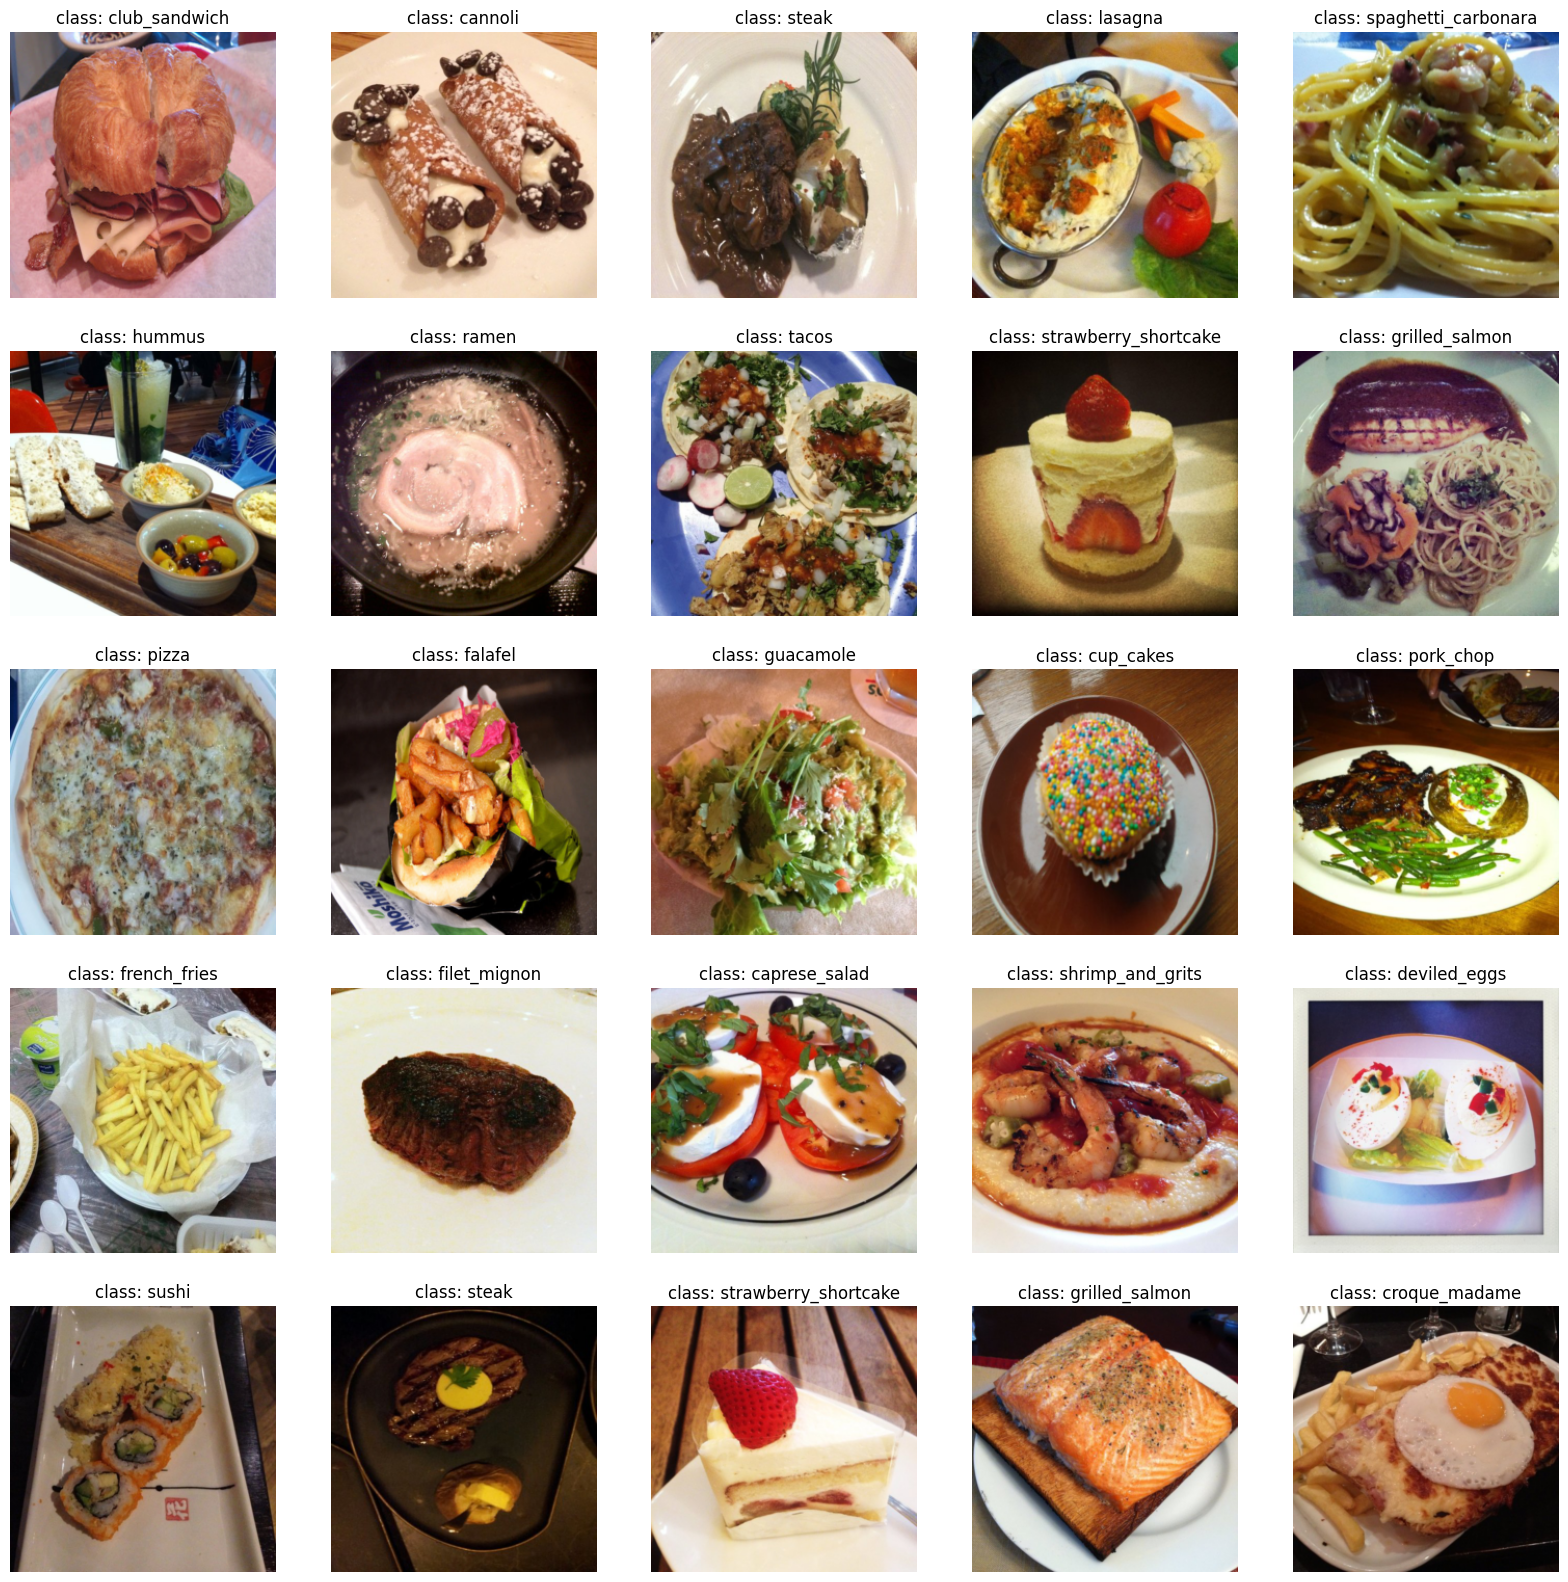

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. PyTorch's Default ViT-Base/16 - 102 Classes

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

In [4]:
# Copy the unknown class into the dataset
shutil.copytree(UNKNOWN_DIR_NAME, TARGET_DIR_NAME, dirs_exist_ok=True)

'../data/food-101_100_percent'

In [5]:
# Create dataloaders
IMG_SIZE_2 = 384
BATCH_SIZE = 32
train_dataloader_vitb, test_dataloader_vitb, class_names = create_dataloaders_for_vit(
    vit_model="vitbase16_2", # ViT-Base/16-384
    batch_size=BATCH_SIZE,
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    aug=True,
    num_workers=NUM_WORKERS
    )

# Instantiate the model
vitbase16_2_model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1).to(device)
vitbase16_2_model.heads = torch.nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Unfreeze the base parameters
for parameter in vitbase16_2_model.parameters():
    parameter.requires_grad = True

# Compile model
vitbase16_2_model = torch.compile(vitbase16_2_model, backend="aot_eager")

# Print summary
#summary(vitbase16_2_model,
#        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [6]:
print(f"Is the unknown class in the dataset?: {'unknown' in class_names}")

Is the unknown class in the dataset?: True


Epoch: 19 | Train: | loss: 0.8355 | acc: 0.9872 | fpr: 0.0375 | pauc: 0.0500 | time:  16m30s | lr: 0.0000010000
Epoch: 19 | Test:  | loss: 1.0255 | acc: 0.9276 | fpr: 0.3378 | pauc: 0.0492 | time:   2m54s | lr: 0.0000010000


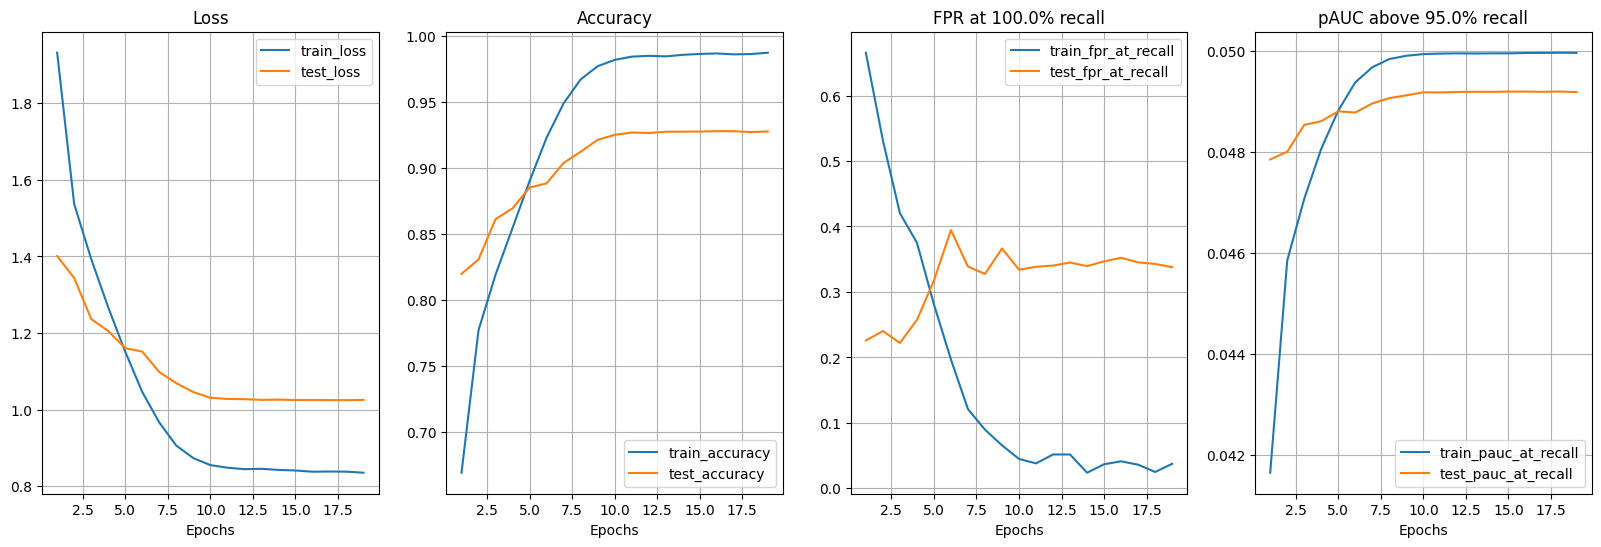

[INFO] Saving model to: ..\models\vitbase16_102_2025-01-27.pth


PermissionError: [Errno 13] Permission denied: '..\\models\\vitbase16_102_2025-01-27.csv'

In [7]:
# Train the model
model_type="vitbase16_102_2025-01-27"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
vitbase16_2_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_2_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) #weight=loss_weights,

# Initialize the scheduler
scheduler = FixedLRSchedulerWrapper(
    scheduler=CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6),
    fixed_lr=1e-6,
    fixed_epoch=10)

# Set seeds
set_seeds(SEED)

# And train...
engine = Engine(
    model=vitbase16_2_model,
    save_best_model=True,
    mode=["acc", "loss", "fpr", "pauc"],
    device=device)

vitbase16_2_results = engine.train(
    target_dir=MODEL_DIR,
    model_name=vitbase16_2_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=1.0,
    recall_threshold_pauc=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2
    )

In [9]:
vitbase16_2_results = pd.read_csv(os.path.join(MODEL_DIR, "vitbase16_102_2025-01-27.csv"))

In [10]:
vitbase16_2_results

epoch  train_loss  train_acc  train_fpr  train_pauc  train_time [s]  \
0       1    1.931691   0.669430   0.665496    0.041654     1021.891620   
1       2    1.536893   0.777269   0.531659    0.045854     1012.721576   
2       3    1.393475   0.819281   0.420438    0.047077     1004.910032   
3       4    1.267212   0.854621   0.375299    0.048068      990.851168   
4       5    1.151486   0.890096   0.281027    0.048824     1002.249144   
5       6    1.046461   0.922940   0.196757    0.049383      982.694012   
6       7    0.966577   0.948876   0.121017    0.049681      979.566115   
7       8    0.906303   0.966991   0.089607    0.049843      979.096838   
8       9    0.873821   0.976945   0.065682    0.049909      975.327976   
9      10    0.855438   0.981754   0.044866    0.049941      976.817791   
10     11    0.848663   0.984212   0.038071    0.049952      984.650820   
11     12    0.844804   0.984826   0.051682    0.049956      981.081524   
12     13    0.845736   0.984395   0.051701    0.049953      990.262835   
13     14    0.842907   0.985571   0.023801    0.049956      994.719957   
14     15    0.841343   0.986251   0.036758    0.049957      987.056576   
15     16    0.838181   0.986630   0.041234    0.049963      976.418191   
16     17    0.838677   0.985937   0.036045    0.049965      973.264608   
17     18    0.838280   0.986177   0.024917    0.049969      980.413907   

    test_loss  test_acc  test_fpr  test_pauc  test_time [s]        lr  
0    1.401133  0.819879  0.225841   0.047856     186.052500  0.000100  
1    1.343568  0.830786  0.240206   0.048008     179.044773  0.000098  
2    1.236818  0.861259  0.221959   0.048540     179.048787  0.000091  
3    1.205346  0.869457  0.257233   0.048614     182.559373  0.000080  
4    1.160597  0.885217  0.317475   0.048809     177.037326  0.000066  
5    1.151577  0.888320  0.394504   0.048785     177.190381  0.000051  
6    1.098213  0.903827  0.338769   0.048965     173.022318  0.000035  
7    1.069283  0.912250  0.327463   0.049070     177.557393  0.000021  
8    1.045999  0.921263  0.366427   0.049125     180.577574  0.000010  
9    1.031191  0.925041  0.334002   0.049185     176.580828  0.000003  
10   1.028058  0.926812  0.338419   0.049182     177.155832  0.000001  
11   1.027432  0.926418  0.340310   0.049191     180.595846  0.000001  
12   1.025605  0.927402  0.344921   0.049196     178.729613  0.000001  
13   1.026297  0.927442  0.339464   0.049193     179.243161  0.000001  
14   1.025266  0.927520  0.346716   0.049200     173.715612  0.000001  
15   1.025301  0.927835  0.352149   0.049199     173.197302  0.000001  
16   1.025096  0.927796  0.345162   0.049194     178.712093  0.000001  
17   1.024937  0.927127  0.342779   0.049200     173.773377  0.000001